In [1]:
from Model import plot_metric
from Model import create_model

import csv
import numpy as np
import pandas as pd
from pickle import dump, load
import os
from keras.callbacks import EarlyStopping, ModelCheckpoint, History
from sklearn.utils import class_weight

np.random.seed(1258)  # for reproducibility


2023-11-07 15:05:43.517230: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-07 15:05:43.566111: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-07 15:05:44.286492: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-11-07 15:05:46.554330: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at htt

In [2]:
save_file_path = '../data/model-results_OnlyPlants/'
    
if not os.path.exists(save_file_path):
    os.mkdir(save_file_path)
    os.mkdir(save_file_path + 'checkpoints/')
    print('-----Directory made-----')
else:
    print('-----Directory already exists-----')
        
print('Loading train-validation-test sequences and labels!')

-----Directory already exists-----
Loading train-validation-test sequences and labels!


In [3]:
train_seq = []
train_label = []
test_seq = []
test_label = []
val_seq = [] 
val_label = []
    
train_seq = np.load('../data/split-train-val-test/train-features-scaled.npz')['arr_0']
train_label = np.load('../data/split-train-val-test/train-labels.npz')['arr_0']
    
val_seq = np.load('../data/split-train-val-test/validation-features-scaled.npz')['arr_0']
val_label = np.load('../data/split-train-val-test/validation-labels.npz')['arr_0']
    
test_seq = np.load('../data/split-train-val-test/test-features-scaled.npz')['arr_0']
test_label = np.load('../data/split-train-val-test/test-labels.npz')['arr_0']

In [4]:
model = create_model(train_seq[0].shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 35, 100)           8500      
                                                                 
 dropout (Dropout)           (None, 35, 100)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 34, 100)           20100     
                                                                 
 dropout_1 (Dropout)         (None, 34, 100)           0         
                                                                 
 attention (attention)       (None, 34, 100)           134       
                                                                 
 bidirectional (Bidirection  (None, 34, 200)           160800    
 al)                                                             
                                                        

In [5]:
history = History()
model_checkpoint = ModelCheckpoint(filepath = save_file_path + 'checkpoints/tada.{epoch:02d}-{val_loss:.2f}.hdf5',\
            save_weights_only=True,\
                monitor='val_loss',\
                    mode='auto',\
                        save_best_only=True)
earlystopper = EarlyStopping(monitor='val_f1_metric', patience=7, verbose=1)
    
callbacks = [
        history,
        model_checkpoint,
        earlystopper
]

In [6]:
#class weights
ground_truth = np.argmax(train_label, axis=-1)
class_weights = class_weight.compute_class_weight('balanced', classes = np.unique(ground_truth), \
        y = ground_truth)
d_class_weights = dict(enumerate(class_weights))

In [7]:
 history = model.fit(train_seq, train_label, batch_size=64,
                        epochs=20, verbose=1, callbacks=callbacks,
                        class_weight = d_class_weights,
                        validation_data=(val_seq, val_label))


Epoch 1/20
756/756 [==============================] - 85s 103ms/step - loss: 0.0338 - precision: 0.9148 - recall: 0.9148 - auc: 0.9610 - accuracy: 0.9148 - aupr: 0.9579 - f1_metric: 0.9148 - val_loss: 0.0279 - val_precision: 0.9190 - val_recall: 0.9190 - val_auc: 0.9713 - val_accuracy: 0.9190 - val_aupr: 0.9690 - val_f1_metric: 0.9193
Epoch 2/20
756/756 [==============================] - 75s 100ms/step - loss: 0.0298 - precision: 0.9184 - recall: 0.9184 - auc: 0.9679 - accuracy: 0.9184 - aupr: 0.9646 - f1_metric: 0.9184 - val_loss: 0.0277 - val_precision: 0.9177 - val_recall: 0.9177 - val_auc: 0.9716 - val_accuracy: 0.9177 - val_aupr: 0.9691 - val_f1_metric: 0.9180
Epoch 3/20
756/756 [==============================] - 75s 99ms/step - loss: 0.0289 - precision: 0.9212 - recall: 0.9212 - auc: 0.9694 - accuracy: 0.9212 - aupr: 0.9661 - f1_metric: 0.9212 - val_loss: 0.0268 - val_precision: 0.9252 - val_recall: 0.9252 - val_auc: 0.9728 - val_accuracy: 0.9252 - val_aupr: 0.9701 - val_f1_metri

In [8]:
model.save('classification_tada.h5')

/home/vspande/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


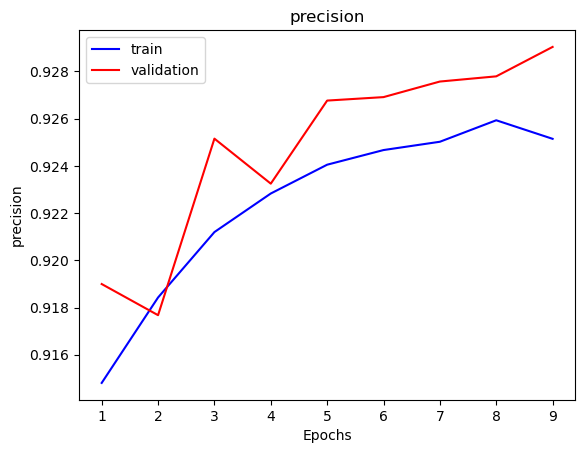

In [9]:
# Plot metrics
model_history = pd.DataFrame(history.history)
training_precision = model_history['precision']#.values()
validation_precision = model_history['val_precision']#.values()
plot_metric(training_precision, validation_precision, 'precision')

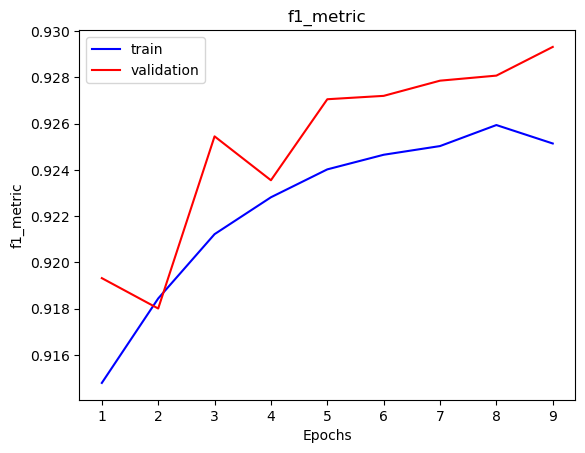

In [10]:
training_f1 = model_history['f1_metric']#.values()
validation_f1 = model_history['val_f1_metric']#.values()
plot_metric(training_f1, validation_f1, 'f1_metric')

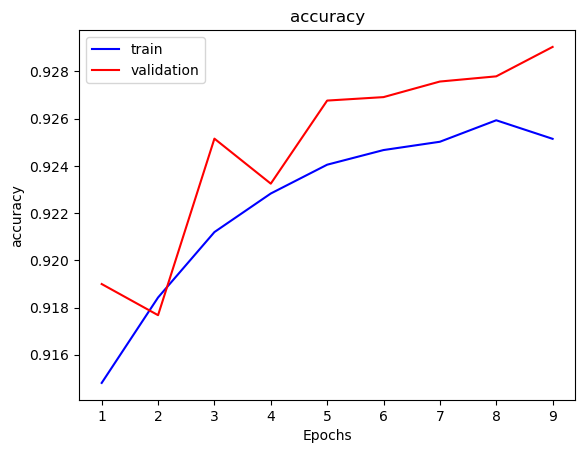

In [11]:
training_accuracy = model_history['accuracy']#.values()
validation_accuracy = model_history['val_accuracy']#.values()
plot_metric(training_accuracy, validation_accuracy, 'accuracy')

In [12]:
!conda list

# packages in environment at /home/vspande/anaconda3/envs/tada2:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                        main  
_openmp_mutex             5.1                       1_gnu  
absl-py                   2.0.0                    pypi_0    pypi
alphapredict              1.0                      pypi_0    pypi
astunparse                1.6.3                    pypi_0    pypi
biopython                 1.81                     pypi_0    pypi
bzip2                     1.0.8                h7b6447c_0  
ca-certificates           2023.7.22            hbcca054_0    conda-forge
cachetools                5.3.2                    pypi_0    pypi
certifi                   2023.7.22                pypi_0    pypi
charset-normalizer        3.3.2                    pypi_0    pypi
cloudpickle               3.0.0                    pypi_0    pypi
contourpy                 1.2.0                    pypi_0    pypi
cycler             